Load HyperParameters

In [1]:
from neat_src import loadHyp, updateHyp
from domain import load_task
from neat_src import DataGatherer, Neat 
from domain.config import games
from domain.task_gym import GymTask

game = games["slimevolley"]
task = GymTask(game)

hyp_default = 'p/default_sneat.json'
hyp_adjust = "p/volley.json"
fileName = "volley"

hyp = loadHyp(pFileName=hyp_default, load_task=load_task)
updateHyp(hyp,load_task,hyp_adjust)

hyp["cap_layer"] = 3
# neat = Neat(hyp)

	*** Running with hyperparameters:  p/volley.json 	***


#### Convert Policy model to Ind in Neat 

In [2]:
import json
import numpy as np
import gym, os
import slimevolleygym
import slimevolleygym.mlp as mlp
from slimevolleygym.mlp import games as games
from slimevolleygym.mlp import Model
from slimevolleygym import multiagent_rollout as rollout

game = games['slimevolleylite']


# of Connections in ANN:  47


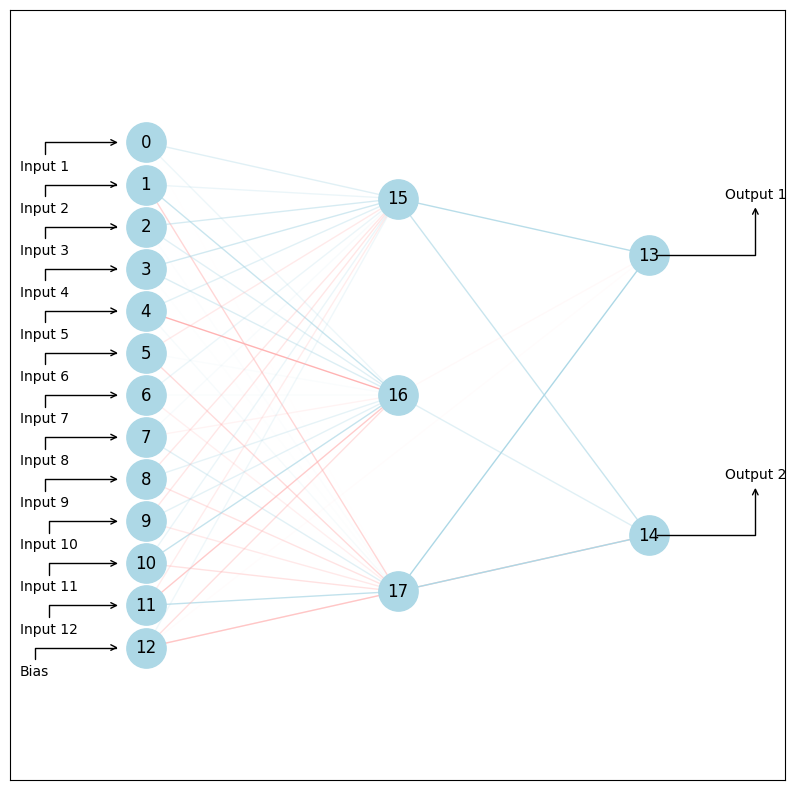

In [3]:
# Slime Environment Specific model -> Ind convertion function 
from neat_src import Ind, initIndiv
from vis.viewInd import viewInd 

temp_shapes = [(12, 3), (3, 2)] # debug getlayer functional variable 

indiv = Ind.from_shapes(temp_shapes)
indiv.express()

# visualize individual network 
fig, ax = viewInd(indiv, "slimevolley") # this is in-correct, edge is not correctly assigned ...

In [14]:
sum(indiv.conn[3,:] ==0) # no zero in the weight (connection)


# w, b = indiv.to_params()[0]
# w[1] # Issue: too many zero values in weight matrix? 


array([-0.582,  0.   ,  0.   ])

In [45]:
self = indiv 
from neat_src import getNodeInfo

# Debug here: 
bias_mask = self.node[1,:] == 4
bias_node_idx = np.where(bias_mask)[0]
node_map, orders, wMat = getNodeInfo(self.node, self.conn)
layers = np.array([node_map[i][0] for i in range(len(node_map))])
params = []
for layer_idx in range(max(layers)):
    curr_layer_mask = (layers == layer_idx) & (~bias_mask)
    next_layer_mask = layers == layer_idx + 1 
    
    curr_mask = np.zeros_like(layers) # index is 'order idx'
    next_mask = np.zeros_like(layers) # index is 'order idx'
    
    for node_idx in range(len(layers)):
        curr_mask[node_map[node_idx][1]] = curr_layer_mask[node_idx]
        next_mask[node_map[node_idx][1]] = next_layer_mask[node_idx]
    curr_mask = np.bool_(curr_mask)
    next_mask = np.bool_(next_mask)
    
    b_idx = node_map[bias_node_idx[0]][1]
    layer_weight = wMat[curr_mask][:, next_mask]
    layer_bias = wMat[b_idx][next_mask]
    params.append((layer_weight, layer_bias))


In [47]:
# layer_weight
layer_bias

0.20100709318041524

In [50]:
wMat[b_idx][next_mask]

array([ 0.201, -0.458, -0.174])

In [49]:
layer_bias

array([ 0.201, -0.458, -0.174])

In [51]:
# Get node organization
bias_idx = np.where(self.node[1,:] == 4)[0][0]  # Get single bias node index
node_map, orders, wMat = getNodeInfo(self.node, self.conn)
layers = np.array([node_map[i][0] for i in range(len(node_map))])

# Get bias node's position in ordered matrix
b_idx = node_map[bias_idx][1]

params = []
for layer_idx in range(max(layers)):
    # Create masks for current and next layer nodes
    curr_layer_nodes = (layers == layer_idx) & (np.arange(len(layers)) != bias_idx)
    next_layer_nodes = (layers == layer_idx + 1)
    
    # Convert node indices to weight matrix indices using node_map
    curr_indices = np.array([node_map[i][1] for i, is_curr in enumerate(curr_layer_nodes) if is_curr])
    next_indices = np.array([node_map[i][1] for i, is_next in enumerate(next_layer_nodes) if is_next])
    
    # Extract weights and bias
    layer_weight = wMat[curr_indices][:, next_indices]
    layer_bias = wMat[b_idx][next_indices]
    
    params.append((layer_weight, layer_bias))

In [54]:
import numpy as np

# Create a simple network with:
# - 2 input nodes (type 1)
# - 1 bias node (type 4)
# - 2 hidden nodes (type 3)
# - 1 output node (type 2)

# Node matrix: [ID, Type, Bias]
node = np.array([
    [0, 1, 0],  # Input 1
    [1, 1, 0],  # Input 2
    [2, 4, 1],  # Bias
    [3, 3, 0],  # Hidden 1
    [4, 3, 0],  # Hidden 2
    [5, 2, 0],  # Output
]).T

# Connection matrix: [In, Out, Weight, Enabled]
conn = np.array([
    # Input -> Hidden connections
    [0, 0, 3, 0.1, 1],
    [1, 0, 4, 0.2, 1],
    [2, 1, 3, 0.3, 1],
    [3, 1, 4, 0.4, 1],
    # Bias -> Hidden connections
    [4, 2, 3, 0.5, 1],
    [5, 2, 4, 0.6, 1],
    # Hidden -> Output connections
    [6, 3, 5, 0.7, 1],
    [7, 4, 5, 0.8, 1],
    # Bias -> Output connection
    [8, 2, 5, 0.9, 1],
]).T

# Test the code
self = type('', (), {})()  # Create dummy object
self.node = node
self.conn = conn

# Now run the parameter extraction code
bias_idx = np.where(self.node[1,:] == 4)[0][0]
node_map, orders, wMat = getNodeInfo(self.node, self.conn)
layers = np.array([node_map[i][0] for i in range(len(node_map))])
b_idx = node_map[bias_idx][1]

params = []
for layer_idx in range(max(layers)):
    curr_layer_nodes = (layers == layer_idx) & (np.arange(len(layers)) != bias_idx)
    next_layer_nodes = (layers == layer_idx + 1)
    
    curr_indices = np.array([node_map[i][1] for i, is_curr in enumerate(curr_layer_nodes) if is_curr])
    next_indices = np.array([node_map[i][1] for i, is_next in enumerate(next_layer_nodes) if is_next])
    
    layer_weight = wMat[curr_indices][:, next_indices]
    layer_bias = wMat[b_idx][next_indices]
    
    params.append((layer_weight, layer_bias))

# Print results
print("Node map:", node_map)
print("\nLayers:", layers)
print("\nWeight matrix:\n", wMat)
print("\nParameters:")
for i, (weights, bias) in enumerate(params):
    print(f"\nLayer {i}:")
    print("Weights:\n", weights)
    print("Bias:", bias)

Node map: {0: [0, 0], 1: [0, 1], 2: [0, 2], 4: [1, 3], 5: [1, 4], 3: [2, 5]}

Layers: [0 0 0 2 1 1]

Weight matrix:
 [[0.  0.  0.  0.1 0.2 0. ]
 [0.  0.  0.  0.3 0.4 0. ]
 [0.  0.  0.  0.5 0.6 0.9]
 [0.  0.  0.  0.  0.  0.7]
 [0.  0.  0.  0.  0.  1. ]
 [0.  0.  0.  0.  0.  0. ]]

Parameters:

Layer 0:
Weights:
 [[0.1 0.2]
 [0.3 0.4]]
Bias: [0.5 0.6]

Layer 1:
Weights:
 [[0.7]
 [1. ]]
Bias: [0.9]


In [23]:
curr_layer_mask

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,  True,  True,  True, False, False, False, False, False, False])

In [19]:
node_map

{0: [0, 0],
 1: [0, 1],
 2: [0, 2],
 3: [0, 3],
 4: [0, 4],
 5: [0, 5],
 6: [0, 6],
 7: [0, 7],
 8: [0, 8],
 9: [0, 9],
 10: [0, 10],
 11: [0, 11],
 12: [0, 12],
 15: [1, 13],
 16: [1, 14],
 17: [1, 15],
 13: [2, 16],
 14: [2, 17]}

In [20]:
np.array([node_map[i][0] for i in range(len(node_map))])

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 1, 1, 1])

In [18]:
layers

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 1, 1, 1])

In [17]:
wMat[curr_layer_mask][:, next_layer_mask]


array([[-0.009,  0.   ,  0.   ],
       [-0.582,  0.   ,  0.   ],
       [ 0.038,  0.   ,  0.   ],
       ...,
       [-0.312,  0.   ,  0.   ],
       [-0.424,  0.   ,  0.   ],
       [ 0.815,  0.   ,  0.   ]])

In [5]:
# Indiv --> Policy Model 
game = games['slimevolleylite']
load_policy = Model.from_indiv(indiv, game)

In [20]:
import matplotlib.pyplot as plt
import matplotlib
from PIL import Image
import io

# Convert matplotlib figure to PIL Image
def fig2img(fig):
    # Save figure to a temporary buffer.
    buf = io.BytesIO()
    fig.savefig(buf, format='png', bbox_inches='tight', pad_inches=0)
    buf.seek(0)
    return Image.open(buf)


# def animate_mutations(shapes, hyp, generations: int = 200, save_name: str = "network_evolution.gif"):
    
frames = []  # Store frames

prev_indiv = Ind.from_shapes([(12, 3)])
prev_indiv.express()

hyp['prob_addNode'] = 0.5
hyp['prob_addConn'] = 0.3
hyp['cap_layer'] = 4
hyp['stop_topology_mutate_generations'] = 200


matplotlib.use('Agg')  # Use Agg backend for better memory management
gen = 1
# Generate and store frames
for i in range(250):
    
    child, innov = prev_indiv.mutate(hyp, gen=gen)    
    if child is False: 
        print("Failed to express :: Bad mutation")
        # break 
    else:
        fig, ax = viewInd(child, "slimevolley")
        prev_indiv = child 
        gen += 1 
        img = fig2img(fig)
        frames.append(img)
        plt.close(fig)

    
# Save frames as GIF directly using PIL
frames[0].save(
    'network_evolution_mix.gif',
    save_all=True,
    append_images=frames[1:],
    duration=500,  # Duration for each frame in milliseconds
    loop=0        # 0 means loop forever
)

# of Connections in ANN:  41
# of Connections in ANN:  43
# of Connections in ANN:  43
# of Connections in ANN:  45
# of Connections in ANN:  46
# of Connections in ANN:  48
# of Connections in ANN:  50
# of Connections in ANN:  53
# of Connections in ANN:  55
# of Connections in ANN:  58
# of Connections in ANN:  58
# of Connections in ANN:  60
# of Connections in ANN:  60
# of Connections in ANN:  61
# of Connections in ANN:  62
# of Connections in ANN:  65
# of Connections in ANN:  65
# of Connections in ANN:  67
# of Connections in ANN:  67
# of Connections in ANN:  68
# of Connections in ANN:  69
# of Connections in ANN:  71
# of Connections in ANN:  72
# of Connections in ANN:  74
# of Connections in ANN:  75
# of Connections in ANN:  75
# of Connections in ANN:  78
# of Connections in ANN:  80
Failed to express :: Bad mutation
# of Connections in ANN:  80
# of Connections in ANN:  81
# of Connections in ANN:  83
# of Connections in ANN:  84
# of Connections in ANN:  84
# of Conn

KeyboardInterrupt: 

In [26]:
# ok, so crossover also works .... | but I'd like to stick to the basic idea (replacing mutation gadgets in the tournament based GA environment)

hyp['prob_addNode'] = 0.5
hyp['prob_addConn'] = 0.3
hyp['cap_layer'] = 4
hyp['stop_topology_mutate_generations'] = 200
hyp['prob_mutConn'] = 1.0 
hyp['ann_mutSigma'] = 0.1 



In [28]:
indiv